In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from PIL import Image

import cv2

import time
from tqdm import tqdm

from iafCA_local import iafCA_local
import pygame

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# brush properties
r = 20
s = 1

def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] + 5.
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] - 0.2
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), 7)
    
    return cdim_order

def min_max(mat):
    return (mat - mat.min()) / (mat.max() - mat.min())

# Test

In [3]:
RADIUS=10

RESX=320
RESY=280

kernel_increment = .2
ca = iafCA_local((RESX, RESY), RADIUS=RADIUS).cuda()
state = ca.initGrid()

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


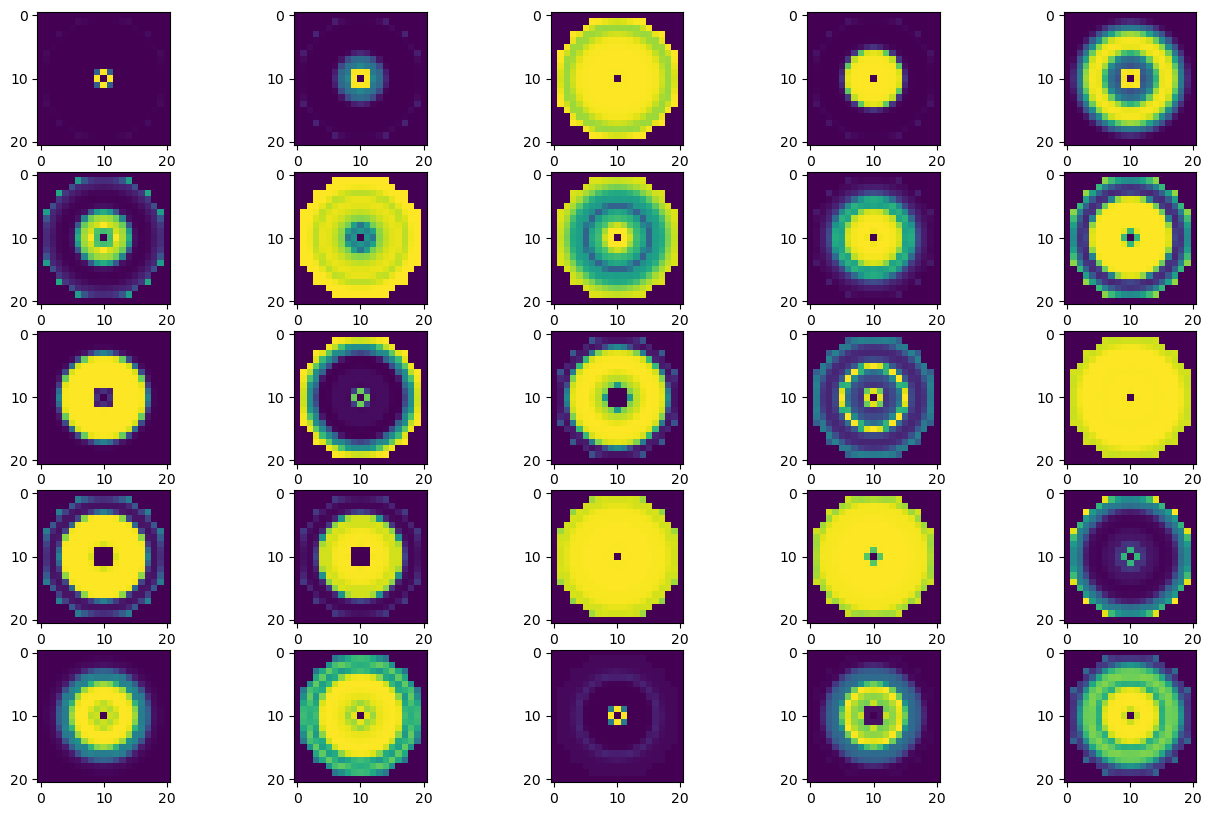

In [4]:
fig, axes = plt.subplots(5, 5, figsize=(16, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(ca.rule.nearest_neighbours.detach().cpu().numpy()[0, :, i*10].reshape(2*RADIUS + 1, 2*RADIUS + 1));

### Init Webcam

In [5]:
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")


In [6]:
ret, web_frame = cap.read()
web_frame = cv2.resize(web_frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)
web_frame = cv2.cvtColor(web_frame, cv2.COLOR_BGR2GRAY)

In [7]:
# target_file = 'target/pug.png'
# target_file = 'target/stripes.jpg'
# target_file = 'target/diagonal-lines-1.jpg'
target_file = 'target/checkerboard.jpg'
target_img = Image.open(target_file).convert('L')
target_img = target_img.resize((RESX,RESY), Image.ANTIALIAS)
target_img = np.array(target_img).transpose() / 255.0
target_img = target_img - target_img.mean()
target_img = torch.cuda.FloatTensor(target_img)
inject_img = False

sign = 1.
t = 0
theta = 0.
X, Y = torch.meshgrid(torch.linspace(-1, 1, RESX), torch.linspace(-1, 1, RESY))

C:\Users\Heysoos\AppData\Local\Temp\ipykernel_12704\199007823.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  target_img = target_img.resize((RESX,RESY), Image.ANTIALIAS)


In [8]:
# pygame stuff
######################################
pygame.init()
size = RESX, RESY

win = pygame.display.set_mode((RESX, RESY))

screen = pygame.Surface(size)
UPSCALE = 2
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

# webcam stuff
######################################
inject_webcam = False
wbcam_fx = RESX / web_frame.shape[1]
wbcam_fy = RESY / web_frame.shape[0] #RESY 
img_norm = 1/255. 

running = True
time_ticking = True
self_organize = False
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, 6)

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################


state = ca.initGrid()
og_kernel = ca.rule.nearest_neighbours
kernel_scale = 1

# inject noise
signal_injection = torch.zeros(size=state.shape)
inject_increment = 1.
noise_amp = 1.
noise_idx = slice(4, 10)

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = -event.y
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -inject_increment
            if event.type == pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += inject_increment
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_k:
                ca.rule.nearest_neighbours = ca.rule.generate_cppn_kernel() 
                og_kernel = ca.rule.nearest_neighbours
            if event.type == pygame.KEYDOWN and event.key == pygame.K_UP:
                kernel_scale += kernel_increment
                ca.rule.nearest_neighbours = og_kernel * kernel_scale
            if event.type == pygame.KEYDOWN and event.key == pygame.K_DOWN:
                kernel_scale -= kernel_increment
                ca.rule.nearest_neighbours = og_kernel * kernel_scale
            if event.type == pygame.KEYDOWN and event.key == pygame.K_w:
                inject_webcam = not inject_webcam
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            # toggle plasticity/lr
            if event.type == pygame.KEYDOWN and event.key == pygame.K_o:
                ca.rule.plasticity = not ca.rule.plasticity
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_1:
                ca.rule.target_rate_mat /= 1.5
                print(f'target_rate: {ca.rule.target_rate_mat.mean():.2f}')
            if event.type == pygame.KEYDOWN and event.key == pygame.K_2:
                ca.rule.target_rate_mat *= 1.5
                print(f'target rate: {ca.rule.target_rate_mat.mean():.2f}')
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_9:
                ca.rule.plastic_lr /= 2.
                print(f'plastic_lr: {ca.rule.plastic_lr:.4f}')
            if event.type == pygame.KEYDOWN and event.key == pygame.K_0:
                ca.rule.plastic_lr *= 2.
                print(f'plastic_lr{ca.rule.plastic_lr:.4f}')
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_PLUS:
                ca.rule.constant_current /= 2.
            if event.type == pygame.KEYDOWN and event.key == pygame.K_MINUS:
                ca.rule.constant_current *= 2.
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_PAGEUP:
                theta += 0.1
            if event.type == pygame.KEYDOWN and event.key == pygame.K_PAGEDOWN:
                theta -= 0.1
                
                
            # toggle adaptation
            if event.type == pygame.KEYDOWN and event.key == pygame.K_a:
                ca.rule.adaptation = not ca.rule.adaptation
            
            # toggle energy
            if event.type == pygame.KEYDOWN and event.key == pygame.K_n:
                ca.rule.energy = not ca.rule.energy
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid()
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_g:
                inject_img = not inject_img
                ca.noise = not inject_img
                
                          

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
            
        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False

        nx = state[0, cdim_order[0], :, :].cpu().numpy()
        nx = nx * 255.

        if time_ticking:
            state = ca.forward(state)
            ticker += 1
            
            if inject_webcam:
                ret, frame = cap.read()
                frame = cv2.resize(frame, None, fx=wbcam_fx, fy=wbcam_fy, interpolation=cv2.INTER_AREA)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).transpose()
                frame = frame - frame.mean()
                frame = torch.cuda.FloatTensor(frame) * img_norm * update_rate
                state[0, 1, 0:frame.shape[0], 0:frame.shape[1]] += frame
                # state[0, 4, 0:frame.shape[0], 0:frame.shape[1]] = state[0, 4, 0:frame.shape[0], 0:frame.shape[1]] - 0.5 * frame
                
            if inject_img:
                # if (ticker % 20) == 0:
                    # if sign < 1:
                    #     sign = 1
                    # else:
                    #     sign = -1
                sign = 1.
                state[:, [1], ...] += sign * (target_img.unsqueeze(0).unsqueeze(0) * update_rate)
                
                
                # w = 12
                # if (ticker % 20) == 0:
                #     if theta < np.pi/2:
                #         theta = np.pi/2
                #     else:
                #         theta = 0.
                # Z = (update_rate * torch.cos(ticker + w*(np.cos(theta)*X+np.sin(theta)*Y))).unsqueeze(0).unsqueeze(0).cuda()
                # state[:, [1], ...] += (Z * update_rate)
                
    
        if sink and time_ticking:
            xv, yv = torch.linspace(-1, 1, RESX), torch.linspace(-RESY/RESX, RESY/RESX, RESY)
            X, Y = torch.meshgrid(xv, yv)
            amp = 0.00
            w = 30
            R = torch.sqrt(X**2 + Y**2).cuda()
            state = torch.where(R > 0.5, state - 0.5 * torch.ones_like(state).cuda(), state)

        if export_imgs and time_ticking:
            imgs.append(nx)
            # imgs.append(state[0, [0, 1, 4, 5], ...].cpu().numpy())
            
        mat_draw = min_max(ca.rule.nearest_neighbours[0, :, RESX*RESY // 2].reshape(2*RADIUS + 1,2*RADIUS + 1).detach()).cpu().numpy()
        connectivity_mat = pygame.transform.scale(pygame.surfarray.make_surface(mat_draw*255.), (50, 50))
        

        pygame.surfarray.blit_array(screen, nx)
        screen.blit(connectivity_mat, (RESX - 50,0))
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        # upscaled_screen.blit(connectivity_mat, (RESX - 50,0))
        pygame.display.flip()
        clock.tick(120)
        
pygame.quit()


plastic_lr0.0002
plastic_lr0.0004
plastic_lr0.0008
plastic_lr0.0016
plastic_lr0.0032
plastic_lr0.0064
plastic_lr0.0128
plastic_lr0.0256
plastic_lr0.0512
plastic_lr0.1024
plastic_lr0.2048
plastic_lr0.4096
plastic_lr0.8192
plastic_lr1.6384
plastic_lr: 0.8192
plastic_lr1.6384
plastic_lr3.2768


In [9]:
import torch.nn.functional as F
self = ca.rule
self.plasticity = True
x = state

Rk = self.radius

pre = F.pad(x[:, [3], ...], (Rk, Rk, Rk, Rk), mode='circular')  # pre-trace
pre = F.unfold(pre, 2*Rk + 1)

pre_spike = F.pad(x[:, [0], ...], (Rk, Rk, Rk, Rk), mode='circular')  # pre-trace
pre_spike = F.unfold(pre_spike, 2*Rk + 1)

x[:, [0], ...] = x[:, [0], ...] * self.EI
S = F.pad(x[:, [0], ...], (Rk, Rk, Rk, Rk), mode='circular') #spikes
V = x[:, [1], ...] # voltages
R = x[:, [2], ...] # + ((torch.rand_like(V) > 0.5) * 2. - 1.) # refractory time
A = x[:, [3], ...] # traces
T = x[:, [4], ...] # threshold
E = x[:, [5], ...] # energy

I = F.unfold(S, 2*Rk + 1) * self.nearest_neighbours
I = I.sum(dim=1).view(1, 1, self.RES[0], self.RES[1]) ## fancier integration than sum? dendridic computation here
V = V - self.decay_constant * V + self.integration_constant * I + self.constant_current
S = (V > T) * (R > self.refractor_time) * (E > self.min_energy) * 1.

# update cell properties
R = (R + 1) * (1 - S)
A = A - A/100 + S
V = V * (1 - S)

if self.plasticity:
    post = F.unfold(A, 1)  # post-trace
    post_spike = F.unfold(S, 1)
    # delta = (pre * (post - F.unfold(self.target_rate_mat, 1))) * (self.nearest_neighbours > 1e-6) # * (F.unfold(self.EI, 1) < 0.)))

    delta_E = (-pre_spike * post + post_spike * pre) * (~self.if_inhib)
    delta_I = (pre_spike * (post - F.unfold(self.target_rate_mat, 1)) + post_spike * pre) * self.if_inhib
    delta = delta_E + delta_I
    delta[:, Rk * (2 * Rk + 1) + Rk, :] = 0  # set center pixel to 0
    # delta = delta * (self.nearest_neighbours > 1e-6)

    new_k = torch.clip(self.nearest_neighbours + self.plastic_lr * delta, min=0)
    new_k[:, Rk * (2 * Rk + 1) + Rk, :] = 0  # set center pixel to 0
    new_k_I = new_k * self.if_inhib
    new_k_I = new_k_I / (new_k_I.sum(dim=1) + 1e-6) * self.k_sums_I
    new_k_E = new_k * (~self.if_inhib)
    new_k_E = new_k_E / (new_k_E.sum(dim=1) + 1e-6) * self.k_sums_E
    new_k = new_k_I + 0.5 * new_k_E
    # new_k = new_k * (self.nearest_neighbours > 1e-6)


    self.nearest_neighbours = 0.9 * self.nearest_neighbours  + 0.1 * new_k

NameError: name 'idx' is not defined

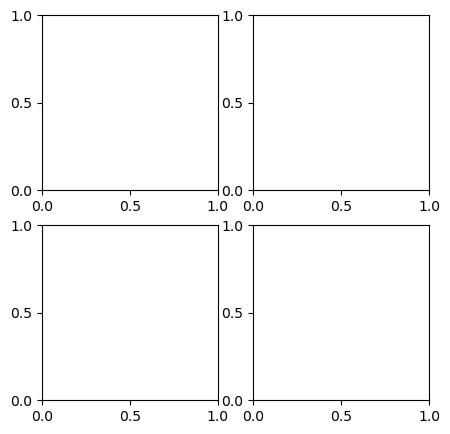

In [10]:
import matplotlib.patches as patches


# idx = np.random.choice(torch.where(post_spike)[-1].cpu().numpy(), 1)

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
plt.rcParams.update({'font.size': 20})

axes = axes.flatten()

############## ax 1
pre_and_post_spike = pre_spike[0, :, idx].reshape(Rk*2 + 1, Rk*2 + 1)
pre_and_post_spike[Rk, Rk] += post_spike[0, 0, idx][0]
im0 = axes[0].imshow(pre_and_post_spike.cpu().numpy())

# Create a Rectangle patch
rect = patches.Rectangle((Rk - 0.5, Rk - 0.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
axes[0].add_patch(rect)

plt.colorbar(im0, ax=axes[0], shrink=0.7, ticks = [0, 1])
axes[0].set_title('Spikes')

############# ax2 
pre_and_post_trace = pre[0, :, idx].reshape(Rk*2 + 1, Rk*2 + 1)
pre_and_post_trace[Rk, Rk] += post[0, 0, idx][0]
im1 = axes[1].imshow(pre_and_post_trace.cpu().numpy())

# Create a Rectangle patch
rect = patches.Rectangle((Rk - 0.5, Rk - 0.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
axes[1].add_patch(rect)

plt.colorbar(im1, ax=axes[1], shrink=0.7)
axes[1].set_title('Traces')

############# ax3 

im2 = axes[2].imshow(delta_E[0, :, idx].reshape(Rk*2 + 1, Rk*2 + 1).cpu().numpy())
plt.colorbar(im2, ax=axes[2], shrink=0.7)
axes[2].set_title(r'$\Delta W$')

im3 = axes[3].imshow(self.nearest_neighbours[0, :, idx].reshape(Rk*2 + 1, Rk*2 + 1).detach().cpu().numpy())
plt.colorbar(im3, ax=axes[3], shrink=0.7)
axes[3].set_title(r'$W_{ij}$')

for ax in axes:
    ax.axis('off')

plt.tight_layout()

# plt.savefig('figs/delta_W_example.pdf', bbox_inches='tight')

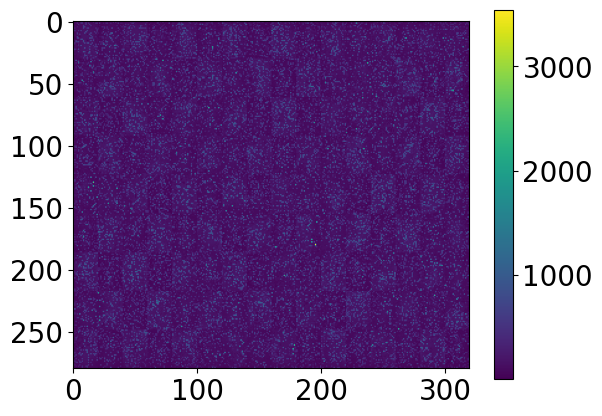

In [54]:
plot2 = F.fold(ca.rule.nearest_neighbours, output_size=(RESX+2*RADIUS, RESY+2*RADIUS), kernel_size=(2*RADIUS + 1))[0, 0].detach().cpu().numpy()

plot2[:RADIUS,:] = plot2[:RADIUS,:] + plot2[-RADIUS:, :]
plot2[:, :RADIUS] = plot2[:, :RADIUS] + plot2[:, -RADIUS:]
plot2 = plot2[RADIUS:-RADIUS, RADIUS:-RADIUS]

plt.imshow(plot2.T); plt.colorbar()

In [ ]:
plt.hist(ca.rule.nearest_neighbours.cpu().numpy().reshape(-1), 100); plt.yscale('symlog'); # plt.xscale('log');

In [ ]:
excite_idx = torch.where(ca.rule.EI.reshape(-1) > 0.)[0].cpu().numpy()
inhib_idx = torch.where(ca.rule.EI.reshape(-1) < 0.)[0].cpu().numpy()

In [ ]:
s = 15
#for s in np.arange(5, 21, 5):

num_rows = s
num_columns = s
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 10))

#rnd_idx = np.random.randint(0, len(excite_idx), 25)
stride_i = RESY // num_rows
stride_j = RESX // num_columns
for i in range(num_rows):
    for j in range(num_columns):
        k = ca.rule.nearest_neighbours
        k = k.reshape(1, -1, RESX, RESY)[0, :, j*stride_j, i*stride_i].detach().cpu().numpy()
        k = k.reshape(2*RADIUS + 1, 2*RADIUS + 1).T

        ei_c = ca.rule.EI[0, 0, j*stride_j, i*stride_i].detach().cpu().numpy()
        cmap = 'Blues' if ei_c > 0. else 'Reds'
        axes[i, j].imshow(k, cmap=cmap);
        axes[i, j].axis('off')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
ax1 = axes[0, 0].imshow(ca.rule.nearest_neighbours[..., excite_idx].detach().cpu().mean(dim=-1).numpy().reshape(2*RADIUS + 1, 2*RADIUS + 1)); 
ax2 = axes[0, 1].imshow(ca.rule.nearest_neighbours[..., excite_idx].detach().cpu().std(dim=-1).numpy().reshape(2*RADIUS + 1, 2*RADIUS + 1)); 
axes[0, 0].set_title('Mean Excitatory Kernel')
axes[0, 1].set_title('Std. Excitatory Kernel')

ax3 = axes[1, 0].imshow(ca.rule.nearest_neighbours[..., inhib_idx].detach().cpu().mean(dim=-1).numpy().reshape(2*RADIUS + 1, 2*RADIUS + 1)); 
ax4 = axes[1, 1].imshow(ca.rule.nearest_neighbours[..., inhib_idx].detach().cpu().std(dim=-1).numpy().reshape(2*RADIUS + 1, 2*RADIUS + 1)); 
axes[1, 0].set_title('Mean Inhibitory Kernel')
axes[1, 1].set_title('Std. Inhibitory Kernel')

plt.colorbar(ax1, ax=axes[0, 0], shrink=0.7)
plt.colorbar(ax2, ax=axes[0, 1], shrink=0.7)
plt.colorbar(ax3, ax=axes[1, 0], shrink=0.7)
plt.colorbar(ax4, ax=axes[1, 1], shrink=0.7)

for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
axes = axes.flatten()

axes[0].hist(state[0, 1].cpu().numpy().reshape(-1), 100);
axes[0].set_title('Voltages')
axes[1].hist(state[0, 0].cpu().numpy().reshape(-1), 100);
axes[1].set_title('Spikes')
axes[2].hist(state[0, 2].cpu().numpy().reshape(-1), 100);
axes[2].set_title('Refractory time')

axes[3].hist(state[0, 3].cpu().numpy().reshape(-1), 100)
axes[3].set_title('Trace rate')
axes[4].hist(state[0, 4].cpu().numpy().reshape(-1), 100)
axes[4].set_title('Threshold')
axes[5].hist(state[0, 5].cpu().numpy().reshape(-1), 100)
axes[5].set_title('Energy')
plt.tight_layout()

In [ ]:
xxx

In [ ]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 60, (RESX, RESY), 1)


for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

In [ ]:
window = 10
for idx_start in np.arange(0, 400, 50):

    plt.figure(figsize=(12, 12))
    plt.imshow(np.mean(imgs[idx_start:idx_start + window], axis=0).transpose())
    plt.axis('off')
    
    # plt.savefig(f'poster_figs/t_ginger_f{str(idx_start).zfill(3)}.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'poster_figs/ginger_f{str(idx_start).zfill(3)}.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'poster_figs/memory_ginger_f{str(idx_start).zfill(3)}.png', dpi=300, bbox_inches='tight')

In [ ]:
ncol = 2
nrow = 4
fig, axes = plt.subplots(ncol, nrow, figsize=(nrow * 4, ncol * 4))

skip = int(len(imgs) / len(axes.flatten()))
for i, ax in enumerate(axes.flatten()):
    idx = i * skip
    ax.imshow(imgs[idx][0])
    ax.set_xlabel(f't={idx}')
    
plt.tight_layout()

In [ ]:
idx = 285
window = 1


plt.figure(figsize=(16, 5))

params = {'axes.labelsize': 16,
          'axes.titlesize': 24}
plt.rcParams.update(params)

plt.subplot(1, 4, 1)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[0].transpose())
plt.title('Spikes')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[1].transpose())
plt.title('Voltages')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[2].transpose())
plt.title('Thresholds')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(np.mean(imgs[idx:idx + window], axis=0)[3].transpose())
plt.title('Energy')
plt.axis('tight')
plt.axis('scaled')
plt.axis('off')


plt.tight_layout()
#plt.savefig('poster_figs/activity.pdf', bbox_inches='tight', dpi=300)
# plt.savefig('poster_figs/activity.png', bbox_inches='tight', dpi=300)

In [ ]:
plt.plot(np.stack(imgs)[:, 0, 1])